Read slides and tumor masks from the [CAMELYON16](https://camelyon17.grand-challenge.org/Data/) dataset. It will install and use [OpenSlide](https://openslide.org/), the only non-Python dependency. Note that OpenSlide also includes a [DeepZoom viewer](https://github.com/openslide/openslide-python/tree/master/examples/deepzoom), shown in class. 

### Training data

This [folder](https://drive.google.com/drive/folders/1rwWL8zU9v0M27BtQKI52bF6bVLW82RL5?usp=sharing) contains a few slides and tumor masks prepared in advance with ASAP. This amount of data (or less!) should be sufficient for your project. The goal is to build a thoughtful end-to-end prototype, not to match the accuracy from the [paper](https://arxiv.org/abs/1703.02442) discussed in class. If you would like more data than has been provided, you will need to use ASAP to convert it into an appropriate format. 


In [0]:
# Install the OpenSlide C library and Python bindings
!apt-get install openslide-tools
!pip install openslide-python

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-410
Use 'apt autoremove' to remove it.
The following additional packages will be installed:
  libopenslide0
Suggested packages:
  libtiff-tools
The following NEW packages will be installed:
  libopenslide0 openslide-tools
0 upgraded, 2 newly installed, 0 to remove and 6 not upgraded.
Need to get 92.5 kB of archives.
After this operation, 268 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libopenslide0 amd64 3.4.1+dfsg-2 [79.8 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 openslide-tools amd64 3.4.1+dfsg-2 [12.7 kB]
Fetched 92.5 kB in 1s (161 kB/s)
Selecting previously unselected package libopenslide0.
(Reading database ... 131304 files and directories currently installed.)
Preparing to unpack .../libopenslide0_3.4.1+dfsg-2_

In [0]:
! pip install wget

  Stored in directory: /root/.cache/pip/wheels/40/15/30/7d8f7cea2902b4db79e3fea550d7d7b85ecb27ef992b618f3f
Successfully built wget


In [0]:
import wget

In [0]:
! ls -l --block-size=M

total 1M
drwxr-xr-x 1 root root 1M Apr  4 20:20 sample_data


In [0]:
! mkdir pos pos_label neg neg_label

In [102]:
! ls

adc.json  neg  neg_label  pos  pos_label  sample_data


In [71]:
from google.colab import drive
drive.mount('/gdrive')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [0]:
# Install the PyDrive wrapper & import libraries.
# This only needs to be done once in a notebook.
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
# This only needs to be done once in a notebook.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from openslide import open_slide, __library_version__ as openslide_version
import os
from PIL import Image
from skimage.color import rgb2gray
from tqdm import tqdm
from sklearn.utils import shuffle
import shutil

In [0]:
import cv2
from google.colab.patches import cv2_imshow

In [74]:
!ls -l --block-size=M '/gdrive/My Drive/Colab Notebooks/slides'

total 32938M
-r-------- 1 root root   94M Oct 11  2018  tumor_001_mask.tif
-r-------- 1 root root 3114M Oct 11  2018  tumor_001.tif
-r-------- 1 root root    1M Oct 11  2018  tumor_001.xml
-r-------- 1 root root   94M Oct 11  2018  tumor_002_mask.tif
-r-------- 1 root root 1603M Oct 11  2018  tumor_002.tif
-r-------- 1 root root    1M Oct 11  2018  tumor_002.xml
-r-------- 1 root root   94M Oct 11  2018  tumor_005_mask.tif
-r-------- 1 root root 1400M Oct 11  2018  tumor_005.tif
-r-------- 1 root root    1M Oct 11  2018  tumor_005.xml
-r-------- 1 root root   92M Oct 11  2018  tumor_012_mask.tif
-r-------- 1 root root 1552M Oct 11  2018  tumor_012.tif
-r-------- 1 root root    1M Oct 11  2018  tumor_012.xml
-r-------- 1 root root   95M Oct 11  2018  tumor_016_mask.tif
-r-------- 1 root root 1454M Oct 11  2018  tumor_016.tif
-r-------- 1 root root    1M Oct 11  2018  tumor_016.xml
-r-------- 1 root root   94M Oct 11  2018  tumor_019_mask.tif
-r-------- 1 root root 1466M Oct 11  2018  tu

##NOTE:
This block is to test how to save gray scale img to google drive, don't run this part

In [0]:
img=cv2.imread('/gdrive/My Drive/Colab Notebooks/tmp/pos_label/091_label_56_68.png')

In [0]:
img.shape

(256, 256, 3)

In [0]:
img=img[:,:,0]
img*=255

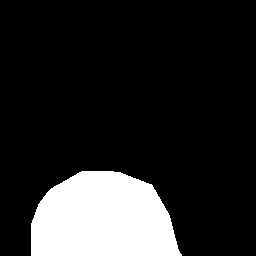

In [0]:
cv2_imshow(img)

In [0]:
cv2.imwrite('tmp.jpg',img)

True

In [0]:
img.shape

(256, 256)

(256, 256)


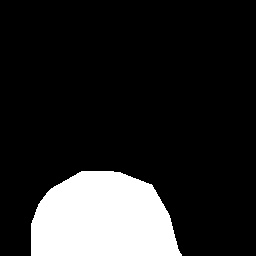

In [0]:
#by using cv2.IMREAD_UNCHANGED, it's reading a img with its original num of channel rather than converting to 3 channels
tmp_img=cv2.imread('tmp.jpg',cv2.IMREAD_UNCHANGED)
print(tmp_img.shape)
cv2_imshow(tmp_img)

In [0]:
upload_to_folder('1uWNSUbHZZCpn-NXjKwf-i9a0C6hlx2WZ', 'tmp.jpg', 'tmp.jpg')

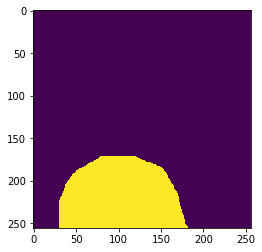

In [0]:
plt.imshow(img)

test complete. procedure: mask[:,:,0], then mask*=255, save to local, then upload to google drive

##Note:
This part is about general visualization of nearly all slides

In [77]:
#get file in folder
files=os.listdir('/gdrive/My Drive/Colab Notebooks/slides')
files[:2]

['tumor_091_mask.tif', 'tumor_091.tif']

In [78]:
#get file name for slide & mask
slide_paths,tumor_mask_paths=[],[]
for item in files:
  if item[-4:] == '.tif':
    if item[-8:-4] == 'mask':
      tumor_mask_paths.append(item)
    else:
      slide_paths.append(item)
print('In total: %d slides.' % len(tumor_mask_paths))
slide_index = [item[6:9] for item in slide_paths]
print('Index of slides:',slide_index)

In total: 21 slides.
Index of slides: ['091', '001', '002', '005', '012', '016', '019', '023', '031', '035', '038', '057', '059', '064', '075', '078', '081', '084', '094', '096', '110', '101']


In [79]:
#get level info about all slides
for i,item in enumerate(slide_paths):
  real_path = '/gdrive/My Drive/Colab Notebooks/slides/'+item
  slide=open_slide(real_path)
  print ("Slide no. %s with %d levels, width: %d, height: %d" % (slide_index[i],
                                                                      len(slide.level_dimensions),
                                                                      slide.level_dimensions[0][0], 
                                                                      slide.level_dimensions[0][1]))

Slide no. 091 with 8 levels, width: 61440, height: 53760
Slide no. 001 with 10 levels, width: 97792, height: 221184
Slide no. 002 with 10 levels, width: 97792, height: 219648
Slide no. 005 with 10 levels, width: 97792, height: 219648
Slide no. 012 with 10 levels, width: 97792, height: 215552
Slide no. 016 with 10 levels, width: 97792, height: 221184
Slide no. 019 with 10 levels, width: 97792, height: 219648
Slide no. 023 with 10 levels, width: 97792, height: 221184
Slide no. 031 with 10 levels, width: 97792, height: 221184
Slide no. 035 with 10 levels, width: 97792, height: 221184
Slide no. 038 with 10 levels, width: 97792, height: 221184
Slide no. 057 with 10 levels, width: 97792, height: 220672
Slide no. 059 with 10 levels, width: 97280, height: 221184
Slide no. 064 with 10 levels, width: 97792, height: 220672
Slide no. 075 with 9 levels, width: 90112, height: 78848
Slide no. 078 with 9 levels, width: 94208, height: 111104
Slide no. 081 with 9 levels, width: 90112, height: 100352
Sli

In [0]:
# Read a region from the slide
# Return a numpy RBG array
def read_slide(slide, x, y, level, width, height, as_float=False):
    im = slide.read_region((x,y), level, (width, height))
    im = im.convert('RGB') # drop the alpha channel
    if as_float:
        im = np.asarray(im, dtype=np.float32)
    else:
        im = np.asarray(im)
    assert im.shape == (height, width, 3)
    return im

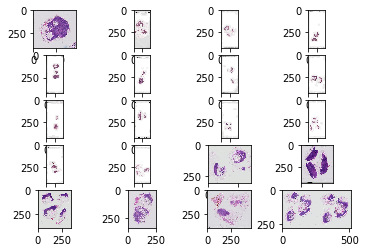

In [81]:
#show imgs at highest level to see general shape
for i in range(20):
  real_path = '/gdrive/My Drive/Colab Notebooks/slides/'+slide_paths[i]
  slide=open_slide(real_path)
  plt.subplot(5,4,i+1)
  level = len(slide.level_dimensions)-1
  slide_image = read_slide(slide, 
                           x=0, 
                           y=0, 
                           level=level, 
                           width=slide.level_dimensions[level][0], 
                           height=slide.level_dimensions[level][1])
  plt.imshow(slide_image)
plt.show()

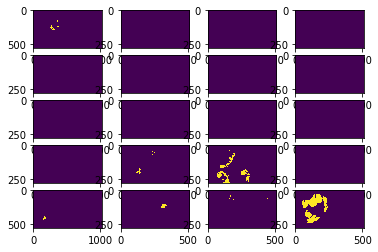

In [82]:
#show masks at highest level to see general shape
for i in range(20):
  real_path = '/gdrive/My Drive/Colab Notebooks/slides/'+tumor_mask_paths[i]
  mask=open_slide(real_path)
  plt.subplot(5,4,i+1)
  level = len(mask.level_dimensions)-1
  mask_image = read_slide(mask, 
                           x=0, 
                           y=0, 
                           level=level, 
                           width=slide.level_dimensions[level][0], 
                           height=slide.level_dimensions[level][1])
  mask_image = mask_image[:,:,1]
  plt.imshow(mask_image)
plt.show()

(2240, 4096, 3)


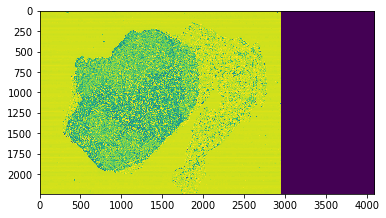

In [83]:
#experiment code block for displaying some img quickly
real_path = '/gdrive/My Drive/Colab Notebooks/slides/'+slide_paths[20]
mask=open_slide(real_path)
level = 5#len(mask.level_dimensions)-1
mask_image = read_slide(mask, 
                         x=0, 
                         y=0, 
                         level=level, 
                         width=slide.level_dimensions[level][0], 
                         height=slide.level_dimensions[level][1])
print(mask_image.shape)
mask_image = mask_image[:,:,2]
plt.imshow(mask_image)
plt.show()

##Note:
This part is about displaying a patch from slides to determine proper level for the project

In [0]:
slide_path = '/gdrive/My Drive/Colab Notebooks/slides/'+slide_paths[0]
tumor_mask_path = '/gdrive/My Drive/Colab Notebooks/slides/'+tumor_mask_paths[0]

In [85]:
slide = open_slide(slide_path)
print ("Read WSI from %s with width: %d, height: %d" % (slide_path, 
                                                        slide.level_dimensions[0][0], 
                                                        slide.level_dimensions[0][1]))

tumor_mask = open_slide(tumor_mask_path)
print ("Read tumor mask from %s" % (tumor_mask_path))

print("Slide includes %d levels", len(slide.level_dimensions))
for i in range(len(slide.level_dimensions)-1):
    print("Level %d, dimensions: %s downsample factor %d" % (i, 
                                                             slide.level_dimensions[i], 
                                                             slide.level_downsamples[i]))
    assert tumor_mask.level_dimensions[i][0] == slide.level_dimensions[i][0]
    assert tumor_mask.level_dimensions[i][1] == slide.level_dimensions[i][1]

# Verify downsampling works as expected
width, height = slide.level_dimensions[7]
assert width * slide.level_downsamples[7] == slide.level_dimensions[0][0]
assert height * slide.level_downsamples[7] == slide.level_dimensions[0][1]

Read WSI from /gdrive/My Drive/Colab Notebooks/slides/tumor_091.tif with width: 61440, height: 53760
Read tumor mask from /gdrive/My Drive/Colab Notebooks/slides/tumor_091_mask.tif
Slide includes %d levels 8
Level 0, dimensions: (61440, 53760) downsample factor 1
Level 1, dimensions: (30720, 26880) downsample factor 2
Level 2, dimensions: (15360, 13440) downsample factor 4
Level 3, dimensions: (7680, 6720) downsample factor 8
Level 4, dimensions: (3840, 3360) downsample factor 16
Level 5, dimensions: (1920, 1680) downsample factor 32
Level 6, dimensions: (960, 840) downsample factor 64


In [0]:
# See https://openslide.org/api/python/#openslide.OpenSlide.read_region
# Note: x,y coords are with respect to level 0.
# There is an example below of working with coordinates
# with respect to a higher zoom level.

# Read a region from the slide
# Return a numpy RBG array
def read_slide(slide, x, y, level, width, height, as_float=False):
    im = slide.read_region((x,y), level, (width, height))
    im = im.convert('RGB') # drop the alpha channel
    if as_float:
        im = np.asarray(im, dtype=np.float32)
    else:
        im = np.asarray(im)
    assert im.shape == (height, width, 3)
    return im

level: 1, width: 30720, height: 26880


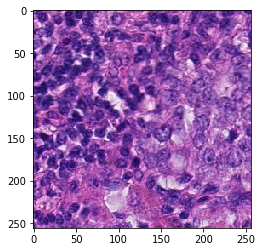

In [87]:
# Example: read the entire slide at level 5

# Higher zoom levels may not fit into memory.
# You can use the below function to extract regions from higher zoom levels 
# without having to read the entire image into ram.

# Use the sliding window approach discussed in class to collect training
# data for your classifier. E.g., slide a window across the slide (for
# starters, use a zoomed out view, so you're not working with giant images).
# Save each window to disk as an image. To find the label for that image, 
# check to the tissue mask to see if the same region contains cancerous cells.

# Important: this is tricky to get right. Carefully debug your pipeline before
# training your model. Start with just a single image, and a relatively 
# low zoom level.
level= 1
width=slide.level_dimensions[level][0]
height=slide.level_dimensions[level][1]
print('level: %d, width: %d, height: %d' % (level,width,height))
slide_image = read_slide(slide, 
                         x=32000, 
                         y=32000, 
                         level=level, 
                         width=256, 
                         height=256)

#plt.figure(figsize=(10,10))#, dpi=100)
plt.imshow(slide_image)

(256, 256, 3)


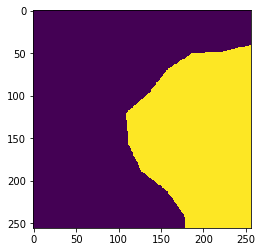

In [88]:
# Example: read the entire mask at the same zoom level
mask_image = read_slide(tumor_mask, 
                        x=32000, 
                        y=32000, 
                        level=level, 
                        width=256, 
                        height=256)

# Note: the program provided by the dataset authors generates a mask with R,G,B channels.
# The mask info we need is in the first channel only.
# If you skip this step, the mask will be displayed as all black.
print(mask_image.shape)
mask_image = mask_image[:,:,0]

#plt.figure(figsize=(10,10))#, dpi=100)
plt.imshow(mask_image)

In [89]:
mask_image[:,-1]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=uint8)

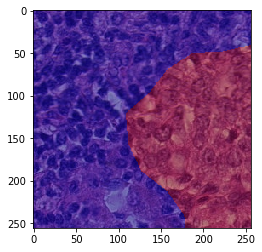

In [92]:
# Overlay them. The idea is that the mask shows the region of the slide that
# contain cancerous cells.
#plt.figure(figsize=(10,10))
plt.imshow(slide_image)
plt.imshow(mask_image, cmap='jet', alpha=0.5) # Red regions contains cancer.

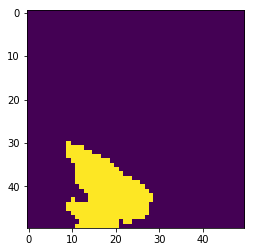

In [93]:
# Example: extract a region from the L7 downsampled image
# Notice we're multiplying the x,y coordinates by the downsample factor.
# This math can be tricky to get right, debug carefully.
# Here, we're "aiming" for the top right blob in the image above.
region = read_slide(tumor_mask, x=350 * 128, y=120 * 128, level=7, width=50, height=50)[:,:,0]
plt.imshow(region)

##Note:
This part is about using a sliding window to cut patches and corresponding labels, then save patches that are in tissue areas to local disk and/or upload to google drive

In [138]:
#get google drive folder list
folder_list = drive.ListFile({'q': "trashed=False"}).GetList()
for folder in folder_list:
  print ('folder title: %s, id: %s' % (folder['title'], folder['id']))

folder title: startercode.ipynb, id: 19EtJNMyYX66aNB0G-RokSvPyboRwQr1x
folder title: all_patch, id: 1H4SPQ0-JholuVLHeUKnCnI78aN8AL_N5
folder title: all_label, id: 1R9l_LultkZSd-ll3bSM0tOUy3d541JlE
folder title: all_img, id: 10srpWJyCBkHmINVfudVsFOqCka4hzjR3
folder title: neg_label, id: 1c37M2S5caZsY2pF9VCoDLrqknFBaKnDq
folder title: neg, id: 1uxwlLXrpQjltn9--5_kn6RwlLrpPgV-0
folder title: Model.ipynb, id: 1bZ2V4FTED5lWYheM60u84Z7uqlYHsGEn
folder title: pos_label, id: 1BoEfV1MjNwJSvMKW0LKSuCvrdbPQqICZ
folder title: pos, id: 1r0sU1fNWd3BlpHdfdCs98vKwqJkovAEs
folder title: tmp.jpg, id: 132n5_Xl1poZDTSCziHTFpjGMWhQs7ZJo
folder title: HW5_part3.ipynb, id: 1ep9MIjGoZhjbjV65BnfSFwmfYEcaBpjl
folder title: 091_label_68_71.png, id: 1hQfxHgKDlvzBYD7JXdxGfior3InwhEMo
folder title: 091_67_71.png, id: 17u1Pp7jaBGuewJhw5Mfcg4wAFxpQhxMK
folder title: 091_label_56_71.png, id: 1ND4PVaEuDj5D076v091JZTtojygvTi__
folder title: 091_label_53_71.png, id: 1URqgfWqugPqNCywYCLzcpng450cWRD9z
folder title: 091_lab

In [0]:
#https://stackoverflow.com/questions/26783420/python-how-to-upload-files-to-a-specific-folder-in-google-drive-using-folderid
def upload_to_folder(folder_id, file_name_local, file_name_in_folder):
    file_metadata = {'title': file_name_in_folder, "parents": [{"id": folder_id, "kind": "drive#childList"}]}
    folder = drive.CreateFile(file_metadata)
    folder.SetContentFile(file_name_local) #The contents of the file
    folder.Upload()

In [0]:
# As mentioned in class, we can improve efficiency by ignoring non-tissue areas 
# of the slide. We'll find these by looking for all gray regions.
def find_tissue_pixels(image, intensity=0.8):
    im_gray = rgb2gray(image)
    assert im_gray.shape == (image.shape[0], image.shape[1])
    indices = np.where(im_gray <= intensity)
    return list(zip(indices[0], indices[1]))

In [95]:
slide_image.shape

(256, 256, 3)

In [96]:
tissue_pixels = find_tissue_pixels(slide_image)
percent_tissue = len(tissue_pixels) / float(slide_image.shape[0] * slide_image.shape[1]) * 100
print ("%d tissue_pixels pixels (%.1f percent of the image)" % (len(tissue_pixels), percent_tissue)) 

64417 tissue_pixels pixels (98.3 percent of the image)


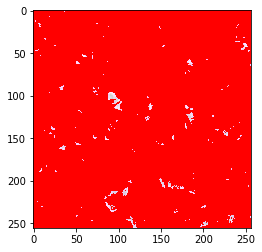

In [97]:
def apply_mask(im, mask, color=(255,0,0)):
    masked = np.copy(im)
    for x,y in mask: masked[x][y] = color
    return masked

tissue_regions = apply_mask(slide_image, tissue_pixels)
plt.imshow(tissue_regions)

In [0]:
#cut slide from areas where intensity level qualifies(use function above to do so), 
#save positive patch & negative patch respectively to:
#pos patch: /Colab Notebooks/tmp/pos/
#pos label: /Colab Notebooks/tmp/pos_label/
#neg patch: /Colab Notebooks/tmp/neg/
#pos label: /Colab Notebooks/tmp/neg_label/
#need to create corresponding folder in google drive
patch_size=[slide.level_dimensions[1][0]//256,slide.level_dimensions[1][1]//256]
patch_size

[120, 105]

In [0]:
#folder id in google drive
folder_id_neg_label = '1drNeRJjhFQyRqWkOrmOv8KRJdKYBKQgu'

folder_id_neg = '1SEYxbz6ps0OtxE85O8yHXLJ0YKWY5q6F'

folder_id_pos_label = '1BoEfV1MjNwJSvMKW0LKSuCvrdbPQqICZ'

folder_id_pos = '1r0sU1fNWd3BlpHdfdCs98vKwqJkovAEs'

In [0]:
#-------------------------------------------------------------------
#NOTE: this function is replaced by generate_data_local() below
#but still have some value: how to save item to google drive
#-------------------------------------------------------------------


#set threshold to be 0.03 for judging if the patch is pos or neg.
#i. e. if sum of mask is smaller than pos_label_intensity, then less than 5% of the label has tumor, label it as negative sample
label_threshold = 0.03
neg_counter = pos_counter = 0
#for tumor, mask[i][j]=1
pos_label_intensity = label_threshold * pow(256,2) #np.sum(np.ones([256,256]))
for col in range(patch_size[0]):
  for row in range(patch_size[1]):
    #get patch
    patch = read_slide(slide, 
                       x=col*2*256, 
                       y=row*2*256, 
                       level=1, 
                       width=256, 
                       height=256)    
    #calculate intensity
    tissue_pixels = find_tissue_pixels(patch)
    percent_tissue = len(tissue_pixels) / float(patch.shape[0] * patch.shape[1]) * 100
    if percent_tissue > 15:
      #save patch & label into google drive
      file_name = slide_index[0]+'_'+str(row)+'_'+str(col)+'.jpg'
      label_name = 'label_'+slide_index[0]+str(row)+'_'+str(col)+'.jpg'
      try:
        #decide if is pos or neg using corresponding mask
        #get mask
        mask_image = read_slide(tumor_mask, 
                       x=col*2*256, 
                       y=row*2*256, 
                       level=1, 
                       width=256, 
                       height=256) 
        mask_image = mask_image[:,:,0]
        #original mask array is read_only, need to make a copy in order to *255
        new_mask=mask_image.copy()
        new_mask*=255
        #save sample & label patch to local disk
        cv2.imwrite(label_name, new_mask)
        cv2.imwrite(file_name, patch)

        #save pos sample
        if np.sum(mask_image) > pos_label_intensity: 
          pos_counter+=1
          print('X: %d, Y: %d, Percent: %.1f, Num_Pos: %d' % (col,row,percent_tissue,pos_counter))
          upload_to_folder(folder_id_pos_label, label_name, label_name)
          upload_to_folder(folder_id_pos, file_name, file_name)
        #save neg sample
        else:
          neg_counter+=1
          print('X: %d, Y: %d, Percent: %.1f, Num_Neg: %d' % (col,row,percent_tissue,neg_counter))
          upload_to_folder(folder_id_neg_label, label_name, label_name)
          upload_to_folder(folder_id_neg, file_name, file_name)
      except Exception as e:
        print(e)

X: 5, Y: 68, Percent: 26.7, Num_Neg: 1
X: 5, Y: 69, Percent: 26.1, Num_Neg: 2
X: 18, Y: 50, Percent: 15.8, Num_Neg: 3
X: 18, Y: 51, Percent: 34.5, Num_Neg: 4
X: 18, Y: 56, Percent: 19.9, Num_Neg: 5
X: 18, Y: 57, Percent: 24.7, Num_Neg: 6
X: 18, Y: 61, Percent: 24.7, Num_Neg: 7
X: 18, Y: 62, Percent: 20.4, Num_Neg: 8
X: 19, Y: 47, Percent: 15.9, Num_Neg: 9
X: 19, Y: 52, Percent: 17.3, Num_Neg: 10
X: 19, Y: 54, Percent: 23.3, Num_Neg: 11
X: 19, Y: 55, Percent: 41.5, Num_Neg: 12
X: 19, Y: 56, Percent: 35.2, Num_Neg: 13
X: 20, Y: 43, Percent: 16.6, Num_Neg: 14
X: 20, Y: 44, Percent: 25.9, Num_Neg: 15
X: 20, Y: 52, Percent: 16.5, Num_Neg: 16
X: 20, Y: 53, Percent: 15.6, Num_Neg: 17
X: 20, Y: 54, Percent: 23.1, Num_Neg: 18
X: 20, Y: 55, Percent: 54.1, Num_Neg: 19
X: 20, Y: 56, Percent: 20.0, Num_Neg: 20
X: 20, Y: 58, Percent: 15.8, Num_Neg: 21
X: 20, Y: 66, Percent: 17.2, Num_Neg: 22
X: 21, Y: 42, Percent: 15.6, Num_Neg: 23
X: 21, Y: 43, Percent: 15.2, Num_Neg: 24
X: 21, Y: 54, Percent: 27.9

KeyboardInterrupt: ignored

In [0]:
print('Num Pos: %d, Num Neg: %d' % (pos_counter,neg_counter))

In [0]:
#same function as above, but doesn't save to google drive, only save on local disk
#set threshold to be 0.03 for judging if the patch is pos or neg.
#i. e. if sum of mask is smaller than pos_label_intensity, then less than 5% of the label has tumor, label it as negative sample
def generate_data_local(slide, label_threshold = 0.03,percent_tissue_threshold = 15):
  #label_threshold = 0.03
  neg_counter = pos_counter = 0
  #for tumor, mask[i][j]=1
  pos_label_intensity = label_threshold * pow(256,2)
  for col in tqdm(range(patch_size[0])):
    for row in range(patch_size[1]):
      #get patch
      patch = read_slide(slide, 
                         x=col*2*256, 
                         y=row*2*256, 
                         level=1, 
                         width=256, 
                         height=256)    
      #calculate intensity
      tissue_pixels = find_tissue_pixels(patch)
      percent_tissue = len(tissue_pixels) / float(patch.shape[0] * patch.shape[1]) * 100
      if percent_tissue > percent_tissue_threshold:
        #save patch & label into google drive
        file_name = slide_index[0]+'_'+str(row)+'_'+str(col)+'.jpg'
        label_name = 'label_'+slide_index[0]+'_'+str(row)+'_'+str(col)+'.jpg'
        try:
          #decide if is pos or neg using corresponding mask
          #get mask
          mask_image = read_slide(tumor_mask, 
                         x=col*2*256, 
                         y=row*2*256, 
                         level=1, 
                         width=256, 
                         height=256) 
          mask_image = mask_image[:,:,0]
          #original mask array is read_only, need to make a copy in order to *255
          new_mask=mask_image.copy()
          new_mask*=255
          #save sample & label patch to local disk
          cv2.imwrite(label_name, new_mask)
          cv2.imwrite(file_name, patch)
          
          #save pos sample
          if np.sum(mask_image) > pos_label_intensity: 
            pos_counter+=1
            #print('X: %d, Y: %d, Percent: %.1f, Num_Pos: %d' % (col,row,percent_tissue,pos_counter))
            cv2.imwrite('pos_label/'+label_name, new_mask)
            cv2.imwrite('pos/'+file_name, patch)
            
          #save neg sample
          else:
            neg_counter+=1
            #print('X: %d, Y: %d, Percent: %.1f, Num_Neg: %d' % (col,row,percent_tissue,neg_counter))
            cv2.imwrite('neg_label/'+label_name, new_mask)
            cv2.imwrite('neg/'+file_name, patch)
        except Exception as e:
          print(e)
  return pos_counter,neg_counter

In [109]:
pos_counter,neg_counter=generate_data_local(slide)

#--------------------------------
#TODO: make a loop for all slides
#only did 1 slide (091) for now
#--------------------------------

 52%|█████▏    | 62/120 [01:04<01:37,  1.68s/it]

X: 62, Y: 61, Percent: 97.6, Num_Pos: 1
X: 62, Y: 62, Percent: 96.7, Num_Pos: 2
X: 62, Y: 64, Percent: 98.7, Num_Pos: 3


 52%|█████▎    | 63/120 [01:05<01:36,  1.69s/it]

X: 63, Y: 61, Percent: 96.9, Num_Pos: 4
X: 63, Y: 62, Percent: 97.4, Num_Pos: 5
X: 63, Y: 63, Percent: 97.1, Num_Pos: 6
X: 63, Y: 64, Percent: 97.8, Num_Pos: 7
X: 63, Y: 65, Percent: 98.4, Num_Pos: 8


 53%|█████▎    | 64/120 [01:07<01:35,  1.70s/it]

X: 64, Y: 60, Percent: 98.9, Num_Pos: 9
X: 64, Y: 61, Percent: 98.9, Num_Pos: 10
X: 64, Y: 62, Percent: 97.1, Num_Pos: 11
X: 64, Y: 63, Percent: 98.5, Num_Pos: 12
X: 64, Y: 64, Percent: 97.6, Num_Pos: 13
X: 64, Y: 65, Percent: 98.0, Num_Pos: 14
X: 64, Y: 66, Percent: 98.4, Num_Pos: 15


 54%|█████▍    | 65/120 [01:09<01:33,  1.71s/it]

X: 65, Y: 59, Percent: 98.0, Num_Pos: 16
X: 65, Y: 60, Percent: 98.0, Num_Pos: 17
X: 65, Y: 61, Percent: 97.6, Num_Pos: 18
X: 65, Y: 62, Percent: 98.2, Num_Pos: 19
X: 65, Y: 63, Percent: 98.7, Num_Pos: 20
X: 65, Y: 64, Percent: 98.7, Num_Pos: 21
X: 65, Y: 65, Percent: 98.8, Num_Pos: 22
X: 65, Y: 66, Percent: 98.9, Num_Pos: 23
X: 65, Y: 67, Percent: 98.4, Num_Pos: 24


 55%|█████▌    | 66/120 [01:11<01:35,  1.77s/it]

X: 66, Y: 58, Percent: 98.6, Num_Pos: 25
X: 66, Y: 59, Percent: 99.1, Num_Pos: 26
X: 66, Y: 60, Percent: 96.8, Num_Pos: 27
X: 66, Y: 61, Percent: 93.6, Num_Pos: 28
X: 66, Y: 62, Percent: 98.3, Num_Pos: 29
X: 66, Y: 63, Percent: 97.2, Num_Pos: 30
X: 66, Y: 64, Percent: 99.5, Num_Pos: 31
X: 66, Y: 65, Percent: 99.1, Num_Pos: 32
X: 66, Y: 66, Percent: 98.8, Num_Pos: 33
X: 66, Y: 67, Percent: 98.3, Num_Pos: 34


 56%|█████▌    | 67/120 [01:14<01:52,  2.13s/it]

X: 67, Y: 57, Percent: 96.8, Num_Pos: 35
X: 67, Y: 58, Percent: 99.1, Num_Pos: 36
X: 67, Y: 59, Percent: 99.0, Num_Pos: 37
X: 67, Y: 60, Percent: 98.2, Num_Pos: 38
X: 67, Y: 61, Percent: 96.5, Num_Pos: 39
X: 67, Y: 62, Percent: 92.9, Num_Pos: 40
X: 67, Y: 63, Percent: 96.7, Num_Pos: 41
X: 67, Y: 64, Percent: 96.4, Num_Pos: 42
X: 67, Y: 65, Percent: 99.1, Num_Pos: 43
X: 67, Y: 66, Percent: 99.4, Num_Pos: 44
X: 67, Y: 67, Percent: 98.6, Num_Pos: 45


 57%|█████▋    | 68/120 [01:15<01:44,  2.01s/it]

X: 68, Y: 56, Percent: 98.4, Num_Pos: 46
X: 68, Y: 57, Percent: 96.9, Num_Pos: 47
X: 68, Y: 58, Percent: 99.1, Num_Pos: 48
X: 68, Y: 59, Percent: 98.8, Num_Pos: 49
X: 68, Y: 60, Percent: 98.5, Num_Pos: 50
X: 68, Y: 61, Percent: 97.7, Num_Pos: 51
X: 68, Y: 62, Percent: 95.5, Num_Pos: 52
X: 68, Y: 63, Percent: 97.4, Num_Pos: 53
X: 68, Y: 64, Percent: 98.3, Num_Pos: 54
X: 68, Y: 65, Percent: 96.7, Num_Pos: 55
X: 68, Y: 66, Percent: 92.6, Num_Pos: 56
X: 68, Y: 67, Percent: 93.1, Num_Pos: 57
X: 68, Y: 68, Percent: 90.1, Num_Pos: 58


 57%|█████▊    | 69/120 [01:24<03:29,  4.10s/it]

X: 69, Y: 57, Percent: 97.9, Num_Pos: 59
X: 69, Y: 58, Percent: 97.4, Num_Pos: 60
X: 69, Y: 59, Percent: 97.8, Num_Pos: 61
X: 69, Y: 60, Percent: 96.9, Num_Pos: 62
X: 69, Y: 61, Percent: 97.4, Num_Pos: 63
X: 69, Y: 62, Percent: 96.6, Num_Pos: 64
X: 69, Y: 63, Percent: 96.0, Num_Pos: 65
X: 69, Y: 64, Percent: 95.7, Num_Pos: 66
X: 69, Y: 65, Percent: 96.5, Num_Pos: 67
X: 69, Y: 66, Percent: 97.6, Num_Pos: 68
X: 69, Y: 67, Percent: 94.5, Num_Pos: 69


 58%|█████▊    | 70/120 [01:26<02:52,  3.45s/it]

X: 70, Y: 57, Percent: 96.3, Num_Pos: 70
X: 70, Y: 58, Percent: 97.1, Num_Pos: 71
X: 70, Y: 59, Percent: 98.3, Num_Pos: 72
X: 70, Y: 60, Percent: 98.3, Num_Pos: 73
X: 70, Y: 61, Percent: 96.5, Num_Pos: 74
X: 70, Y: 62, Percent: 96.5, Num_Pos: 75
X: 70, Y: 63, Percent: 97.3, Num_Pos: 76
X: 70, Y: 64, Percent: 96.5, Num_Pos: 77
X: 70, Y: 65, Percent: 97.4, Num_Pos: 78
X: 70, Y: 66, Percent: 98.1, Num_Pos: 79
X: 70, Y: 67, Percent: 97.9, Num_Pos: 80
X: 70, Y: 68, Percent: 97.5, Num_Pos: 81
X: 70, Y: 71, Percent: 98.4, Num_Pos: 82


 59%|█████▉    | 71/120 [01:37<04:29,  5.50s/it]

X: 71, Y: 57, Percent: 97.2, Num_Pos: 83
X: 71, Y: 58, Percent: 98.4, Num_Pos: 84
X: 71, Y: 59, Percent: 95.7, Num_Pos: 85
X: 71, Y: 60, Percent: 97.9, Num_Pos: 86
X: 71, Y: 61, Percent: 95.8, Num_Pos: 87
X: 71, Y: 62, Percent: 95.0, Num_Pos: 88
X: 71, Y: 63, Percent: 97.5, Num_Pos: 89
X: 71, Y: 64, Percent: 93.1, Num_Pos: 90
X: 71, Y: 65, Percent: 97.5, Num_Pos: 91
X: 71, Y: 66, Percent: 95.1, Num_Pos: 92
X: 71, Y: 70, Percent: 97.6, Num_Pos: 93
X: 71, Y: 71, Percent: 96.3, Num_Pos: 94


 60%|██████    | 72/120 [01:38<03:29,  4.36s/it]

X: 72, Y: 60, Percent: 95.9, Num_Pos: 95
X: 72, Y: 61, Percent: 96.3, Num_Pos: 96
X: 72, Y: 62, Percent: 96.0, Num_Pos: 97
X: 72, Y: 63, Percent: 97.6, Num_Pos: 98
X: 72, Y: 64, Percent: 97.9, Num_Pos: 99
X: 72, Y: 65, Percent: 98.0, Num_Pos: 100
X: 72, Y: 66, Percent: 97.0, Num_Pos: 101
X: 72, Y: 69, Percent: 96.3, Num_Pos: 102
X: 72, Y: 70, Percent: 83.5, Num_Pos: 103
X: 72, Y: 71, Percent: 97.3, Num_Pos: 104
X: 72, Y: 72, Percent: 57.1, Num_Pos: 105


 61%|██████    | 73/120 [01:48<04:42,  6.02s/it]

X: 73, Y: 59, Percent: 95.7, Num_Pos: 106
X: 73, Y: 60, Percent: 96.1, Num_Pos: 107
X: 73, Y: 61, Percent: 96.4, Num_Pos: 108
X: 73, Y: 69, Percent: 95.5, Num_Pos: 109
X: 73, Y: 70, Percent: 97.4, Num_Pos: 110
X: 73, Y: 71, Percent: 96.1, Num_Pos: 111
X: 73, Y: 72, Percent: 89.0, Num_Pos: 112
X: 73, Y: 73, Percent: 47.0, Num_Pos: 113


 62%|██████▏   | 74/120 [01:50<03:36,  4.71s/it]

X: 74, Y: 67, Percent: 96.7, Num_Pos: 114
X: 74, Y: 68, Percent: 96.1, Num_Pos: 115
X: 74, Y: 69, Percent: 97.7, Num_Pos: 116
X: 74, Y: 70, Percent: 98.2, Num_Pos: 117
X: 74, Y: 71, Percent: 98.2, Num_Pos: 118
X: 74, Y: 72, Percent: 97.8, Num_Pos: 119
X: 74, Y: 73, Percent: 89.9, Num_Pos: 120


 62%|██████▎   | 75/120 [02:02<05:16,  7.03s/it]

X: 75, Y: 67, Percent: 97.2, Num_Pos: 121
X: 75, Y: 68, Percent: 92.8, Num_Pos: 122
X: 75, Y: 69, Percent: 89.7, Num_Pos: 123
X: 75, Y: 70, Percent: 94.8, Num_Pos: 124
X: 75, Y: 71, Percent: 96.0, Num_Pos: 125
X: 75, Y: 72, Percent: 98.7, Num_Pos: 126
X: 75, Y: 73, Percent: 95.4, Num_Pos: 127
X: 75, Y: 74, Percent: 59.7, Num_Pos: 128
X: 75, Y: 75, Percent: 45.8, Num_Pos: 129


 63%|██████▎   | 76/120 [02:04<03:57,  5.41s/it]

X: 76, Y: 67, Percent: 95.4, Num_Pos: 130
X: 76, Y: 68, Percent: 91.3, Num_Pos: 131
X: 76, Y: 69, Percent: 95.0, Num_Pos: 132
X: 76, Y: 70, Percent: 97.2, Num_Pos: 133
X: 76, Y: 71, Percent: 98.4, Num_Pos: 134
X: 76, Y: 72, Percent: 98.6, Num_Pos: 135
X: 76, Y: 73, Percent: 96.2, Num_Pos: 136
X: 76, Y: 74, Percent: 88.2, Num_Pos: 137
X: 76, Y: 75, Percent: 81.5, Num_Pos: 138


 64%|██████▍   | 77/120 [02:14<04:51,  6.79s/it]

X: 77, Y: 67, Percent: 96.3, Num_Pos: 139
X: 77, Y: 68, Percent: 87.7, Num_Pos: 140
X: 77, Y: 69, Percent: 94.4, Num_Pos: 141
X: 77, Y: 70, Percent: 97.9, Num_Pos: 142
X: 77, Y: 71, Percent: 99.1, Num_Pos: 143
X: 77, Y: 72, Percent: 98.7, Num_Pos: 144
X: 77, Y: 73, Percent: 97.9, Num_Pos: 145
X: 77, Y: 74, Percent: 95.3, Num_Pos: 146
X: 77, Y: 75, Percent: 93.3, Num_Pos: 147


 65%|██████▌   | 78/120 [02:16<03:41,  5.26s/it]

X: 78, Y: 67, Percent: 98.5, Num_Pos: 148
X: 78, Y: 68, Percent: 95.9, Num_Pos: 149
X: 78, Y: 69, Percent: 94.6, Num_Pos: 150
X: 78, Y: 70, Percent: 98.9, Num_Pos: 151
X: 78, Y: 71, Percent: 99.3, Num_Pos: 152
X: 78, Y: 72, Percent: 99.0, Num_Pos: 153
X: 78, Y: 73, Percent: 98.6, Num_Pos: 154
X: 78, Y: 74, Percent: 98.5, Num_Pos: 155
X: 78, Y: 75, Percent: 72.2, Num_Pos: 156


 66%|██████▌   | 79/120 [02:25<04:26,  6.50s/it]

X: 79, Y: 69, Percent: 90.9, Num_Pos: 157
X: 79, Y: 70, Percent: 95.8, Num_Pos: 158
X: 79, Y: 71, Percent: 99.6, Num_Pos: 159
X: 79, Y: 72, Percent: 98.9, Num_Pos: 160
X: 79, Y: 73, Percent: 98.9, Num_Pos: 161
X: 79, Y: 74, Percent: 98.5, Num_Pos: 162
X: 79, Y: 75, Percent: 65.8, Num_Pos: 163


 67%|██████▋   | 80/120 [02:27<03:22,  5.06s/it]

X: 80, Y: 69, Percent: 99.3, Num_Pos: 164
X: 80, Y: 70, Percent: 94.6, Num_Pos: 165
X: 80, Y: 71, Percent: 94.2, Num_Pos: 166
X: 80, Y: 72, Percent: 96.8, Num_Pos: 167
X: 80, Y: 73, Percent: 97.6, Num_Pos: 168
X: 80, Y: 74, Percent: 94.8, Num_Pos: 169
X: 80, Y: 75, Percent: 78.9, Num_Pos: 170


 68%|██████▊   | 81/120 [02:36<04:02,  6.22s/it]

X: 81, Y: 72, Percent: 99.7, Num_Pos: 171
X: 81, Y: 73, Percent: 99.2, Num_Pos: 172
X: 81, Y: 74, Percent: 94.1, Num_Pos: 173
X: 81, Y: 75, Percent: 96.3, Num_Pos: 174


 73%|███████▎  | 88/120 [03:11<02:44,  5.13s/it]

X: 88, Y: 60, Percent: 98.1, Num_Pos: 175
X: 88, Y: 61, Percent: 97.8, Num_Pos: 176
X: 88, Y: 62, Percent: 95.1, Num_Pos: 177


 74%|███████▍  | 89/120 [03:20<03:14,  6.27s/it]

X: 89, Y: 37, Percent: 99.6, Num_Pos: 178
X: 89, Y: 38, Percent: 99.2, Num_Pos: 179
X: 89, Y: 40, Percent: 98.3, Num_Pos: 180
X: 89, Y: 41, Percent: 97.4, Num_Pos: 181
X: 89, Y: 42, Percent: 99.3, Num_Pos: 182
X: 89, Y: 43, Percent: 98.5, Num_Pos: 183
X: 89, Y: 59, Percent: 98.7, Num_Pos: 184
X: 89, Y: 60, Percent: 98.3, Num_Pos: 185
X: 89, Y: 61, Percent: 98.8, Num_Pos: 186
X: 89, Y: 62, Percent: 98.8, Num_Pos: 187
X: 89, Y: 63, Percent: 95.6, Num_Pos: 188


 75%|███████▌  | 90/120 [03:22<02:25,  4.84s/it]

X: 90, Y: 37, Percent: 98.6, Num_Pos: 189
X: 90, Y: 38, Percent: 99.6, Num_Pos: 190
X: 90, Y: 39, Percent: 98.8, Num_Pos: 191
X: 90, Y: 40, Percent: 97.9, Num_Pos: 192
X: 90, Y: 41, Percent: 98.7, Num_Pos: 193
X: 90, Y: 42, Percent: 99.1, Num_Pos: 194
X: 90, Y: 43, Percent: 98.9, Num_Pos: 195
X: 90, Y: 57, Percent: 98.3, Num_Pos: 196
X: 90, Y: 58, Percent: 94.6, Num_Pos: 197
X: 90, Y: 59, Percent: 97.7, Num_Pos: 198
X: 90, Y: 60, Percent: 98.3, Num_Pos: 199
X: 90, Y: 61, Percent: 97.8, Num_Pos: 200
X: 90, Y: 62, Percent: 98.9, Num_Pos: 201
X: 90, Y: 63, Percent: 97.5, Num_Pos: 202
X: 90, Y: 64, Percent: 99.3, Num_Pos: 203


 76%|███████▌  | 91/120 [03:30<02:49,  5.86s/it]

X: 91, Y: 38, Percent: 99.4, Num_Pos: 204
X: 91, Y: 39, Percent: 99.2, Num_Pos: 205
X: 91, Y: 40, Percent: 97.1, Num_Pos: 206
X: 91, Y: 41, Percent: 95.9, Num_Pos: 207
X: 91, Y: 42, Percent: 99.7, Num_Pos: 208
X: 91, Y: 57, Percent: 98.6, Num_Pos: 209
X: 91, Y: 58, Percent: 98.1, Num_Pos: 210
X: 91, Y: 59, Percent: 99.5, Num_Pos: 211
X: 91, Y: 60, Percent: 98.4, Num_Pos: 212
X: 91, Y: 61, Percent: 98.2, Num_Pos: 213
X: 91, Y: 62, Percent: 98.3, Num_Pos: 214
X: 91, Y: 63, Percent: 99.5, Num_Pos: 215
X: 91, Y: 64, Percent: 98.9, Num_Pos: 216
X: 91, Y: 65, Percent: 99.3, Num_Pos: 217


 77%|███████▋  | 92/120 [03:32<02:07,  4.55s/it]

X: 92, Y: 38, Percent: 99.5, Num_Pos: 218
X: 92, Y: 39, Percent: 99.3, Num_Pos: 219
X: 92, Y: 40, Percent: 98.6, Num_Pos: 220
X: 92, Y: 41, Percent: 99.2, Num_Pos: 221
X: 92, Y: 42, Percent: 98.5, Num_Pos: 222
X: 92, Y: 56, Percent: 96.4, Num_Pos: 223
X: 92, Y: 57, Percent: 98.2, Num_Pos: 224
X: 92, Y: 58, Percent: 97.9, Num_Pos: 225
X: 92, Y: 59, Percent: 98.1, Num_Pos: 226
X: 92, Y: 60, Percent: 98.9, Num_Pos: 227
X: 92, Y: 61, Percent: 98.1, Num_Pos: 228
X: 92, Y: 62, Percent: 96.1, Num_Pos: 229
X: 92, Y: 63, Percent: 99.3, Num_Pos: 230
X: 92, Y: 64, Percent: 99.4, Num_Pos: 231
X: 92, Y: 65, Percent: 96.8, Num_Pos: 232


 78%|███████▊  | 93/120 [03:40<02:35,  5.77s/it]

X: 93, Y: 39, Percent: 99.1, Num_Pos: 233
X: 93, Y: 40, Percent: 98.1, Num_Pos: 234
X: 93, Y: 41, Percent: 94.6, Num_Pos: 235
X: 93, Y: 56, Percent: 96.9, Num_Pos: 236
X: 93, Y: 57, Percent: 96.2, Num_Pos: 237
X: 93, Y: 58, Percent: 97.6, Num_Pos: 238
X: 93, Y: 59, Percent: 98.7, Num_Pos: 239
X: 93, Y: 60, Percent: 96.7, Num_Pos: 240
X: 93, Y: 61, Percent: 93.4, Num_Pos: 241
X: 93, Y: 62, Percent: 96.0, Num_Pos: 242
X: 93, Y: 63, Percent: 97.5, Num_Pos: 243
X: 93, Y: 64, Percent: 95.6, Num_Pos: 244
X: 93, Y: 65, Percent: 96.5, Num_Pos: 245


 78%|███████▊  | 94/120 [03:42<01:55,  4.45s/it]

X: 94, Y: 40, Percent: 96.1, Num_Pos: 246
X: 94, Y: 41, Percent: 97.3, Num_Pos: 247
X: 94, Y: 57, Percent: 98.0, Num_Pos: 248
X: 94, Y: 58, Percent: 96.9, Num_Pos: 249
X: 94, Y: 59, Percent: 98.0, Num_Pos: 250
X: 94, Y: 60, Percent: 94.1, Num_Pos: 251
X: 94, Y: 61, Percent: 78.0, Num_Pos: 252
X: 94, Y: 62, Percent: 56.5, Num_Pos: 253
X: 94, Y: 63, Percent: 48.5, Num_Pos: 254
X: 94, Y: 64, Percent: 53.3, Num_Pos: 255
X: 94, Y: 65, Percent: 49.4, Num_Pos: 256


 79%|███████▉  | 95/120 [03:49<02:14,  5.38s/it]

X: 95, Y: 57, Percent: 49.3, Num_Pos: 257
X: 95, Y: 58, Percent: 73.5, Num_Pos: 258
X: 95, Y: 59, Percent: 81.0, Num_Pos: 259
X: 95, Y: 62, Percent: 55.9, Num_Pos: 260
X: 95, Y: 63, Percent: 32.9, Num_Pos: 261


100%|██████████| 120/120 [04:46<00:00,  1.23it/s]


In [110]:
print('Num Pos: %d, Num Neg: %d' % (pos_counter,neg_counter))

Num Pos: 261, Num Neg: 4276


In [0]:
#get item from directory
pos_label_dir = os.listdir('pos_label')
pos_dir = os.listdir('pos')
neg_label_dir = os.listdir('neg_label')
neg_dir = os.listdir('neg')

In [125]:
len(pos_dir),len(neg_dir)

(261, 4276)

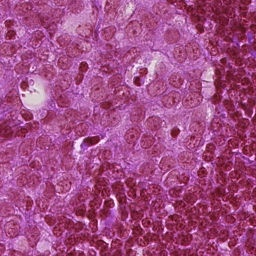

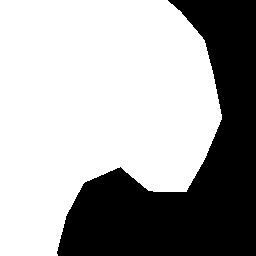

------------------------------------


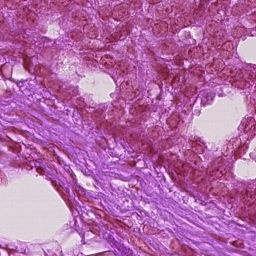

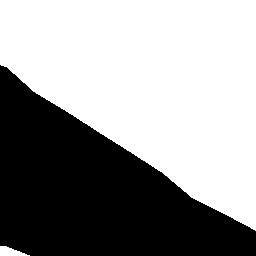

------------------------------------


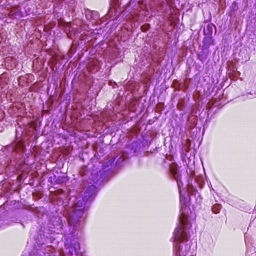

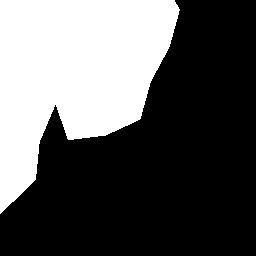

------------------------------------


In [134]:
#show some label with corresponding patch
for item in pos_dir[:3]:
  img = cv2.imread('pos/'+item, cv2.IMREAD_UNCHANGED)
  cv2_imshow(img)
  img = cv2.imread('pos_label/label_'+item, cv2.IMREAD_UNCHANGED)
  cv2_imshow(img)
  print('------------------------------------')

In [0]:
#! rm -rf all_patch all_label
! mkdir all_patch all_label

In [0]:
#Balancing data: select 2*(num of pos) data from neg, to reduce imbalancement
#then move selected data to all_patch & all_label

#-----------------------------------------------------------------------------------------
#Note: This is a temporal method, idealy, should only do data augmentation for pos data, 
#then select same amount of data from neg so that neg data is more generalized
#-----------------------------------------------------------------------------------------
neg_dir = shuffle(neg_dir)
for item in neg_dir[:2*len(pos_dir)]:
  shutil.copyfile(item,'all_patch/'+item)
  shutil.copyfile('neg_label/label_'+item,'all_label/label_'+item)

for item in pos_dir:
  shutil.copyfile(item,'all_patch/'+item)
  shutil.copyfile('pos_label/label_'+item,'all_label/label_'+item)

In [133]:
all_patch_dir = os.listdir('all_patch')
all_label_dir = os.listdir('all_label')
print('item in all_patch: %d, item in all_label: %d' % (len(all_patch_dir),len(all_label_dir)))

item in all_patch: 783, item in all_label: 783


In [0]:
#save item in all_patch & all_label to google drive
def save_folder_to_gdrive(path, folder_id, header):  
  for item in tqdm(path):
    try:
      upload_to_folder(folder_id, header+item, item)
    except Exception as exc:
      print(exc, item)    

In [0]:
#get folder id from folder list acquired above
folder_id_all_patch = '1H4SPQ0-JholuVLHeUKnCnI78aN8AL_N5'
folder_id_all_label = '1R9l_LultkZSd-ll3bSM0tOUy3d541JlE'

In [145]:
save_folder_to_gdrive(all_patch_dir, folder_id_all_patch, 'all_patch/')

 84%|████████▍ | 658/783 [17:16<02:31,  1.21s/it]

<HttpError 502 when requesting https://www.googleapis.com/upload/drive/v2/files?alt=json&uploadType=resumable returned "Bad Gateway">


100%|██████████| 783/783 [20:19<00:00,  1.34s/it]


In [146]:
save_folder_to_gdrive(all_label_dir, folder_id_all_label, 'all_label/')

100%|██████████| 783/783 [19:16<00:00,  1.59s/it]
